In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import time 
import shutil
import random

import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import skimage.io
import PIL.Image as Image
import matplotlib.pyplot as plt
%matplotlib inline


# from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir('../chezai/medadata/2nd/temp/'))

# Any results you write to the current directory are saved as output.

['NG', 'OK']


## Pytorch to be backend

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pretrainedmodels import xception,resnext101_32x4d,resnext101_64x4d,resnet101,resnet50,vgg19_bn
from torch.autograd import Variable
from tensorboardX import SummaryWriter

np.random.seed(666)
torch.manual_seed(666)
torch.cuda.manual_seed_all(666)
random.seed(666)

## Load dataset

In [37]:
path_to_train_metadata = '../chezai/medadata/2nd/temp/'
path_to_train_info = 'data/label.csv'
# path_to_test_metadata = '../input/test/'
# path_to_test_info = '../input/sample_submission.csv'

In [38]:
data_info = pd.read_csv(path_to_train_info)
data_info.head()

,Id,Target
0,medadata/2nd/temp/NG\colorbeam\colorbeam_0.bmp,1
1,medadata/2nd/temp/NG\colorbeam\colorbeam_1.bmp,1
2,medadata/2nd/temp/NG\colorbeam\colorbeam_10.bmp,1
3,medadata/2nd/temp/NG\colorbeam\colorbeam_11.bmp,1
4,medadata/2nd/temp/NG\colorbeam\colorbeam_12.bmp,1


### Should know some dataset information

In [39]:
dataset_total_num = data_info.shape[0]
print('We have {} train data'.format(dataset_total_num))

We have 1698 train data


### Get the summary of dataset class number

In [40]:
def dataset_cnt_dict(dataset,data_number):
    class_with_cnt={}
    for i in range(data_number):
        key = np.array(dataset.drop(['Id'],axis=1).Target)[i]
        if key not in class_with_cnt.keys():
            class_with_cnt[key]=0
        class_with_cnt[key]+=1 
    return OrderedDict(sorted(class_with_cnt.items(), key=lambda t: t[1],reverse=True))


In [41]:
class_with_cnt_dict = dataset_cnt_dict(data_info,dataset_total_num)
print(class_with_cnt_dict)

OrderedDict([(0, 703), (7, 441), (3, 220), (6, 152), (4, 127), (1, 55)])


In [42]:
label_names = {
              0:'OK',
              1:'colorbeam',
              2:'ghost',
              3:'innerDust',
              4:'largerLight',
              5:'longbeam',
              6:'multibeam',
              7:'shortbeam',
              }

## Convert dataset class number to class name

In [43]:
def convert_class_to_name(class_with_cnt_dict):
    class_to_name_dict = {label_names[k]:v for k,v in class_with_cnt_dict.items()}
    return OrderedDict(sorted(class_to_name_dict.items(), key=lambda t: t[1],reverse=True))
     

In [44]:
name_with_cnt_dict= convert_class_to_name(class_with_cnt_dict)
class_name = list(name_with_cnt_dict.keys())
class_num = len(class_name)
print(name_with_cnt_dict)
print(class_name)
print(class_num)

OrderedDict([('OK', 703), ('shortbeam', 441), ('innerDust', 220), ('multibeam', 152), ('largerLight', 127), ('colorbeam', 55)])
['OK', 'shortbeam', 'innerDust', 'multibeam', 'largerLight', 'colorbeam']
6


### Representing the dataset 

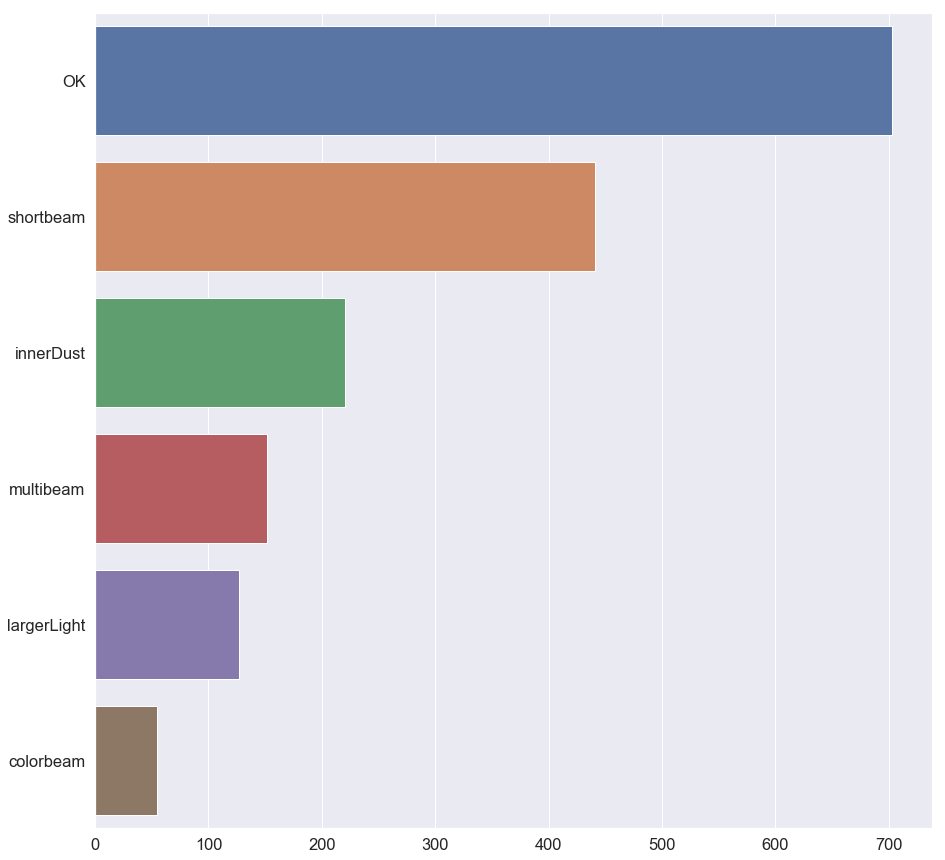

In [45]:
plt.figure(figsize=(15,15))
sns.set(font_scale=1.5)
sns.barplot(y=list(name_with_cnt_dict.keys()), x=list(name_with_cnt_dict.values()))

### Genrate Class Weighted

In [46]:
def get_class_weighted(class_dict):
    total_labels = np.sum(list(class_dict.values()))
    return {k:1.0/(v/total_labels) for k,v in class_dict.items()}

In [47]:
def get_class_ratio(class_dict):
    total_labels = np.sum(list(class_dict.values()))
    return {k:(v/total_labels) for k,v in class_dict.items()}

In [48]:
class_weighted = get_class_weighted(class_with_cnt_dict)
print(class_weighted)

{0: 2.415362731152205, 7: 3.8503401360544216, 3: 7.718181818181818, 6: 11.171052631578947, 4: 13.37007874015748, 1: 30.87272727272727}


In [49]:
class_ratio = get_class_ratio(class_with_cnt_dict)
print(class_ratio)

{0: 0.41401648998822144, 7: 0.2597173144876325, 3: 0.12956419316843346, 6: 0.0895170789163722, 4: 0.07479387514723204, 1: 0.032391048292108364}


## Split dataset as its distribution

In [14]:
val_ratio = 0.20
train_data_list, val_data_list = train_test_split(data_info, test_size=val_ratio, random_state=666,stratify=data_info.Target)
train_data_num = train_data_list.shape[0]
print('Train dataset has {}'.format(train_data_num))
val_data_num = val_data_list.shape[0]
print('Val dataset has {}'.format(val_data_num))

Train dataset has 948
Val dataset has 238


## Let's test whether the splited datasets still follow the previous distribution


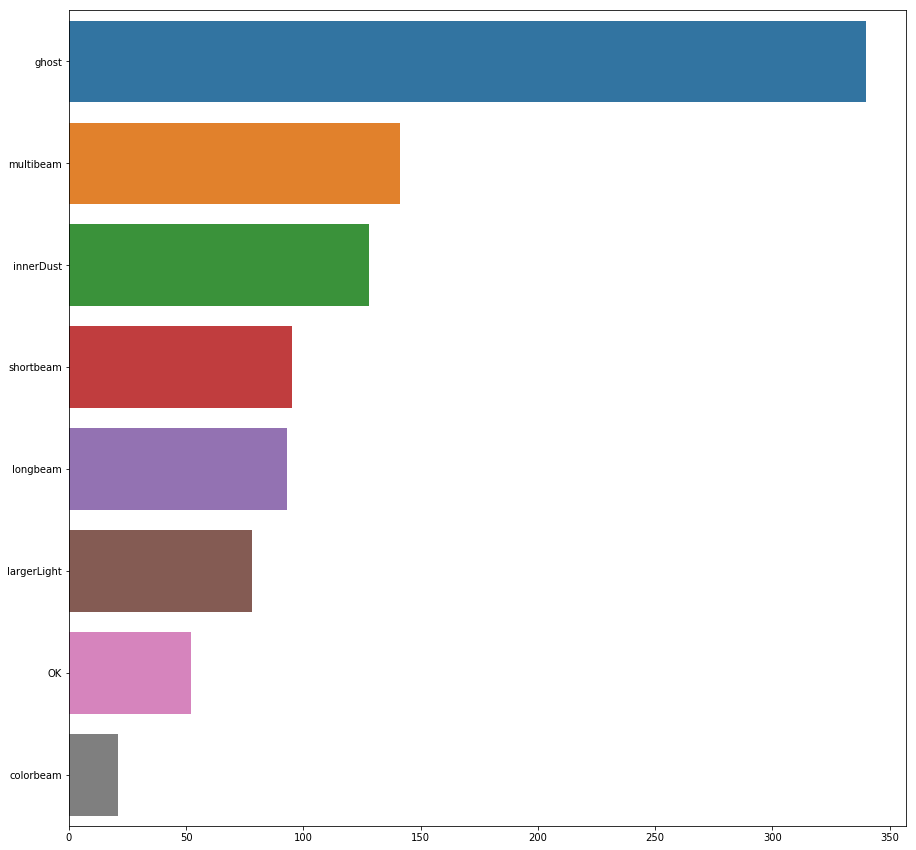

In [15]:
train_class_with_cnt_dict = dataset_cnt_dict(train_data_list,train_data_num)
train_name_with_cnt_dict = convert_class_to_name(train_class_with_cnt_dict)
plt.figure(figsize=(15,15))
sns.barplot(y=list(train_name_with_cnt_dict.keys()), x=list(train_name_with_cnt_dict.values()))

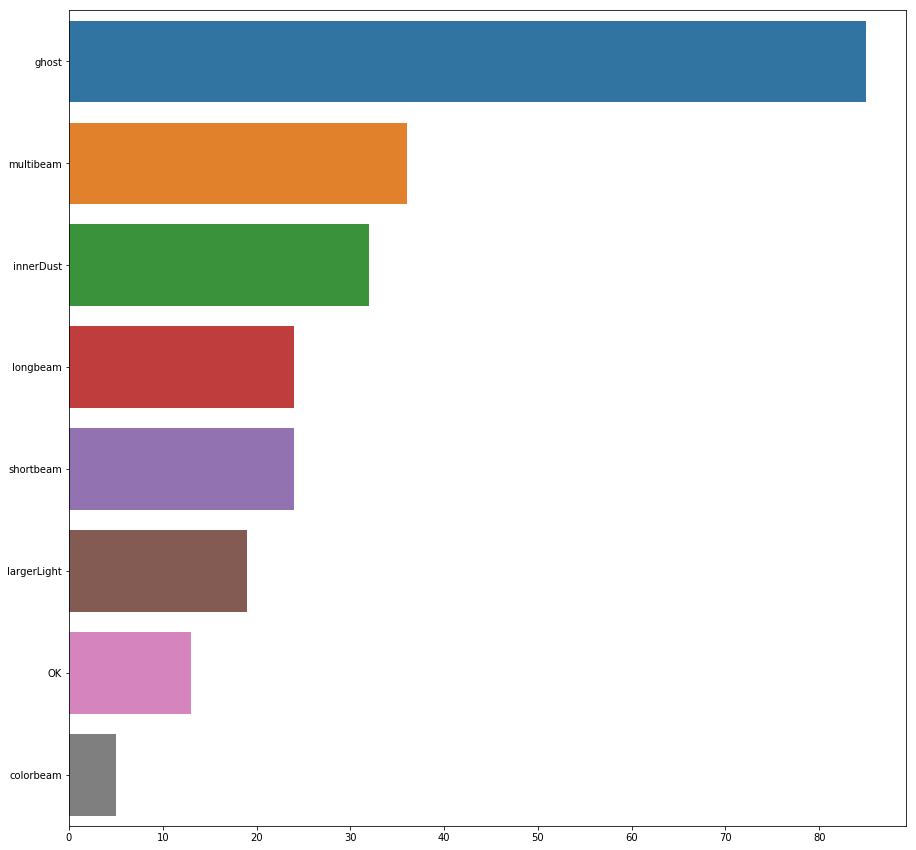

In [16]:
val_class_with_cnt_dict = dataset_cnt_dict(val_data_list,val_data_num)
val_name_with_cnt_dict = convert_class_to_name(val_class_with_cnt_dict)
plt.figure(figsize=(15,15))
sns.barplot(y=list(val_name_with_cnt_dict.keys()), x=list(val_name_with_cnt_dict.values()))

In [17]:
train_class_weighted = get_class_weighted(train_class_with_cnt_dict)
print(train_class_weighted)

{0: 18.23076923076923, 1: 45.142857142857146, 2: 2.788235294117647, 3: 7.406250000000001, 4: 12.153846153846155, 5: 10.193548387096774, 6: 6.723404255319149, 7: 9.978947368421053}


In [18]:
class_weighted = []
for i in range(8):
    class_weighted.append(train_class_weighted[i])

In [19]:
class_weighted

[18.23076923076923,
 45.142857142857146,
 2.788235294117647,
 7.406250000000001,
 12.153846153846155,
 10.193548387096774,
 6.723404255319149,
 9.978947368421053]

# Data Generation

In [20]:
def load_image(path):
        image = skimage.io.imread(path)
#         image_yellow_ch = skimage.io.imread(path+'_yellow.png')
#         image_green_ch = skimage.io.imread(path+'_green.png')
#         image_blue_ch = skimage.io.imread(path+'_blue.png')
        
#         image_red_ch = np.array(Image.open(path+'_red.png'))
#         image_yellow_ch = np.array(Image.open(path+'_yellow.png'))
#         image_green_ch = np.array(Image.open(path+'_green.png'))
#         image_blue_ch = np.array(Image.open(path+'_blue.png'))

#         image_red_ch += (image_yellow_ch/2).astype(np.uint8) 
#         image_green_ch += (image_yellow_ch/2).astype(np.uint8)

#         image = np.stack((
#             image_red_ch, 
#             image_green_ch, 
#             image_blue_ch), -1)
        
        return image

In [21]:
def label_decoder(label,class_num=8):
    label_list = [label]
    label_decoder_list = list(np.zeros(class_num,dtype=np.float32))
    for i in range(class_num):
        if i in label_list:
            label_decoder_list[i]=1.0
    return np.asarray(label_decoder_list,dtype=np.float32)
        

In [22]:
class DatasetGenerate(Dataset):
    def __init__(self, label_list, transform=None, target_transform=None, loader=load_image,decoder=label_decoder):
        imgs = []
        for index, row in label_list.iterrows():
            imgs.append((row['Id'], row['Target']))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.decoder = label_decoder

    def __getitem__(self, index):
        filename, label = self.imgs[index]
        img = self.loader(filename)
        img = Image.fromarray(img,'RGB')
        if self.transform is not None:
            img = self.transform(img)
#         label = self.decoder(label)
        return img, label

    def __len__(self):
        return len(self.imgs)

In [23]:
class TestDataset(Dataset):
    def __init__(self, label_list, transform=None, target_transform=None, loader=load_image):
        imgs = []
        for index, row in label_list.iterrows():
            imgs.append((row['Id']))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = self.loader(filename)
        img = Image.fromarray(img,'RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [24]:
train_dataset = DatasetGenerate(train_data_list)

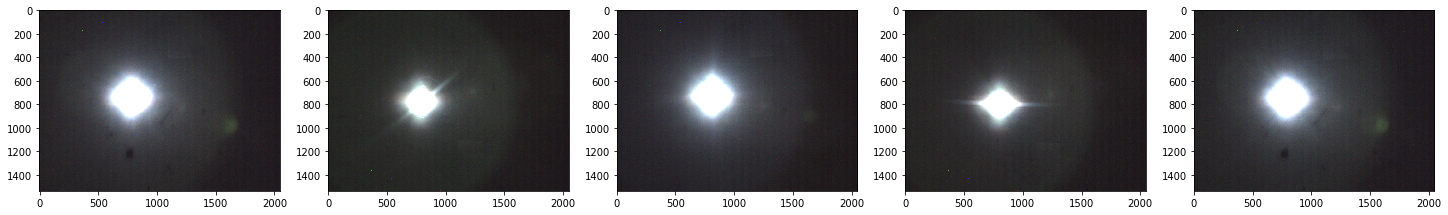

In [25]:
fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(train_dataset.__getitem__(i)[0])

In [26]:
train_dataset.__getitem__(500)[1]

6

# Training Part

## Some useful function

In [27]:
# 获取当前文件名，用于创建模型及结果文件的目录
file_name = 'vgg19_bn_focalloss'
# file_name = 'Xception_focalloss'
# 创建保存模型和结果的文件夹
if not os.path.exists('./model/%s' % file_name):
    os.makedirs('./model/%s' % file_name)
if not os.path.exists('./result/%s' % file_name):
    os.makedirs('./result/%s' % file_name)
# 创建日志文件
if not os.path.exists('./result/%s.txt' % file_name):
    with open('./result/%s.txt' % file_name, 'w') as acc_file:
        pass
with open('./result/%s.txt' % file_name, 'a') as acc_file:
    acc_file.write('\n%s %s\n' % (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(time.time())), file_name))

In [28]:
class AverageMeter(object):
        """Computes and stores the average and current value"""
        def __init__(self):
            self.reset()

        def reset(self):
            self.val = 0
            self.avg = 0
            self.sum = 0
            self.count = 0

        def update(self, val, n=1):
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count

In [29]:
def accuracy(y_pred, y_actual, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    final_acc = 0
    maxk = max(topk)
    # for prob_threshold in np.arange(0, 1, 0.01):
    PRED_COUNT = y_actual.size(0)
    PRED_CORRECT_COUNT = 0
    prob, pred = y_pred.topk(maxk, 1, True, True)
    # prob = np.where(prob > prob_threshold, prob, 0)
    for j in range(pred.size(0)):
        if int(y_actual[j]) == int(pred[j]):
            PRED_CORRECT_COUNT += 1
    if PRED_COUNT == 0:
        final_acc = 0
    else:
        final_acc = PRED_CORRECT_COUNT / PRED_COUNT
    return final_acc * 100, PRED_COUNT

In [30]:
def f1(y_pred,y_true):
    shape = list(y_pred.shape)
    y_pred = F.log_softmax(y_pred)
    one_hot = torch.cuda.FloatTensor(shape[0],shape[1]).zero_()
    target = one_hot.scatter_(1, y_true.cuda().long().unsqueeze(1), 1.0)
    tp = torch.sum(target*y_pred,dim=0)
    tn = torch.sum((1-target)*(1-y_pred),dim=0)
    fp = torch.sum((1-target)*y_pred,dim=0)
    fn = torch.sum(target*(1-y_pred),dim=0)
    precision = tp / (tp+fp+1e-8)
    recall = tp / (tp+fn+1e-8)
    f1 = 2*precision*recall / (precision+recall+1e-8)
    return torch.mean(f1)

In [31]:
def convert_multi_label_for_cm(y_pred,y_actual,class_num=class_num,prob_threshold=0.5):
    PRED_COUNT = y_actual.size(0)
    temp_array = np.arange(0,class_num).reshape((1,class_num))
    temp_array = temp_array.repeat(PRED_COUNT,axis=0)
    
    pred = np.where(y_pred > prob_threshold,temp_array,0).reshape(-1)
    
    actual = y_actual.cpu().numpy()
    actual = np.where(actual>0,temp_array,8).reshape(-1)
    return pred,actual


In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.tight_layout()

In [33]:
def print_confusion_matrix(confusion_matrix, class_names,normaliza,figsize = (15,15), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fmt = '.2f' if normalize else 'd'
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [34]:
def draw_cm(pred,label,class_num=class_num,prob_threshold=0.5):
    p = pred.cpu().numpy()
    p = np.argmax(p,axis=1)
    l = label.cpu().numpy()
    cln = class_name.copy()
#     cln.append("UNK")
    cnf_matrix = confusion_matrix(l, p,labels=list(range(len(cln))))
    fig = print_confusion_matrix(cnf_matrix, cln,normaliza=False,figsize = (15,15), fontsize=14)
    return fig
#     np.set_printoptions(precision=2)
#     plt.figure()
#     plot_confusion_matrix(cnf_matrix, classes=class_name, normalize=False,title='Normalized confusion matrix')
#     plt.show()

## Training

In [35]:
def test(test_loader, model,thresholder=0.5):
        csv_map = OrderedDict({'filename': [], 'probability': []})
        # switch to evaluate mode
        model.eval()
        for i, (images, filepath) in enumerate(tqdm(test_loader)):
            # bs, ncrops, c, h, w = images.size()
            filepath = [os.path.basename(i) for i in filepath]
            image_var = torch.tensor(images, requires_grad=False)  # for pytorch 0.4

            with torch.no_grad():
                y_pred = model(image_var)
                # sigmoid to prob
                sm = nn.Sigmoid()
                sm_out = sm(y_pred)       
            label_predicts = np.arange(8)[sm_out>=thresholder]
            
            for label_predict in label_predicts:
                str_predict_label = ''
                for i in range(8):
                    if label_predict[i] == 1:
                        str_predict_label = ' '.join(str(i))
                    
                csv_map['probability'].append(str_predict_label)
            csv_map['filename'].extend(filepath)
            
            
        result = pd.DataFrame(csv_map)
    

        
        # 生成结果文件，保存在result文件夹中，可用于直接提交
        submission = pd.DataFrame(csv_map)
        submission.to_csv('./result/%s/submission.csv' % file_name, header=['Id','Predicted'], index=False)

#         prob_map = pd.DataFrame(prob_list)
#         prob_map.to_csv('./result/%s/prob_map.csv' % file_name, header=False, index=False)
        return

In [36]:
def train(train_loader, model, criterion, optimizer, epoch,writer):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
    F1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    # 从训练集迭代器中获取训练数据
    for i, (images, target) in enumerate(train_loader):
        # 评估图片读取耗时
        data_time.update(time.time() - end)
        # 将图片和标签转化为tensor
        image_var = torch.tensor(images).cuda(async=True)
        label = torch.tensor(target).cuda(async=True).long()

        # 将图片输入网络，前传，生成预测值
        y_pred = model(image_var)
        # 计算loss
        loss = criterion(y_pred, label)
        losses.update(loss.item(), images.size(0))

        # 计算正确率
        prec, PRED_COUNT = accuracy(y_pred.data, target)
        f1score = f1(y_pred,target)
        acc.update(prec, PRED_COUNT)
        F1.update(f1score,PRED_COUNT)

        # 对梯度进行反向传播，使用随机梯度下降更新网络权重
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 评估训练耗时
        batch_time.update(time.time() - end)
        end = time.time()
        # 打印耗时与结果
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuray {acc.val:.3f} ({acc.avg:.3f})\t'
                  'F-score {F1.val:.3f} ({F1.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time, loss=losses, acc=acc,F1=F1))
    writer.add_scalar('loss', losses.avg, epoch)
    writer.add_scalar('acc', acc.avg, epoch)
    writer.add_scalar('F-score',F1.avg,epoch)
    return writer

In [37]:
def validate(val_loader, model, criterion,writer,epoch=None):
    csv_map = OrderedDict({'filename': [], 'probability': []})
    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
    F1 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    for i, (images, labels) in enumerate(val_loader):
        image_var = torch.tensor(images).cuda(async=True)
        target = torch.tensor(labels).cuda(async=True)
        numpy.savetxt()
        # 图片前传。验证和测试时不需要更新网络权重，所以使用torch.no_grad()，表示不计算梯度
        with torch.no_grad():
            y_pred = model(image_var)
            loss = criterion(y_pred, target)
        # measure accuracy and record loss
        m = nn.Softmax()
        pred = m(y_pred)
        prec, PRED_COUNT = accuracy(pred.data, labels)
        f1score = f1(y_pred,target)
        losses.update(loss.item(), images.size(0))
        acc.update(prec, PRED_COUNT)
        F1.update(f1score,PRED_COUNT)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i == 0:
            total_y_pred = y_pred
            total_labels = labels
        else:
            total_y_pred = torch.cat((total_y_pred,y_pred),0)
            total_labels = torch.cat((total_labels,labels),0)
        if i % print_freq == 0:
            print('TrainVal: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuray {acc.val:.3f} ({acc.avg:.3f})\t'
                  'F1-Score {F1.val:.3f} ({F1.avg:.3f})'.format(
                i, len(val_loader), batch_time=batch_time, loss=losses, acc=acc,F1=F1))
    print(' * Accuray {acc.avg:.3f}'.format(acc=acc), '(Previous Best Acc: %.3f)' % best_precision,
          ' * Loss {loss.avg:.3f}'.format(loss=losses), '(Previous Lowest Loss: %.3f)' % lowest_loss,
        ' * F1 {F1.avg:}'.format(F1=F1),'(Previous Best F1: %.3f)'%best_F1)
    if epoch:
        writer.add_scalar('loss', losses.avg, epoch)
        writer.add_scalar('acc', acc.avg, epoch)
        writer.add_scalar('F-score',F1.avg,epoch)
    return acc.avg, losses.avg,total_y_pred,total_labels,F1.avg,writer

In [38]:
def save_checkpoint(state, is_best, is_lowest_loss, filename='./model/%s/checkpoint.pth.tar' % file_name):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, './model/%s/model_best.pth.tar' % file_name)
        if is_lowest_loss:
            shutil.copyfile(filename, './model/%s/lowest_loss.pth.tar' % file_name)

In [39]:
class FixedRotation(object):
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        return fixed_rotate(img, self.angles)

def fixed_rotate(img, angles):
    angles = list(angles)
    angles_num = len(angles)
    index = random.randint(0, angles_num - 1)
    return img.rotate(angles[index])

In [40]:
class F1Loss(nn.Module):
    def __init__(self):
        super(F1Loss, self).__init__()
        
    def forward(self,y_pred,y_true):
        m = nn.Sigmoid()
        y_pred = m(y_pred)
        tp = torch.sum(y_true*y_pred,dim=0)
        tn = torch.sum((1-y_true)*(1-y_pred),dim=0)
        fp = torch.sum((1-y_true)*y_pred,dim=0)
        fn = torch.sum(y_true*(1-y_pred),dim=0)
        precision = tp / (tp+fp+1e-8)
        recall = tp / (tp+fn+1e-8)
        
        f1 = 2*precision*recall / (precision+recall+1e-8)
        
        return 1 - torch.mean(f1)
        

In [41]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)
        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())
        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [42]:
import warnings
warnings.filterwarnings(action='once')
trainwriter = SummaryWriter('./result/'+file_name+'/train')
valwriter = SummaryWriter('./result/'+file_name+'/val')
testwriter = SummaryWriter('./result/'+file_name+'/test')

C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: [0][0/40]	Time 6.805 (6.805)	Data 5.218 (5.218)	Loss 14.1945 (14.1945)	Accuray 8.333 (8.333)	F-score 0.277 (0.277)
Epoch: [0][1/40]	Time 5.640 (6.222)	Data 5.472 (5.345)	Loss 14.1691 (14.1818)	Accuray 33.333 (20.833)	F-score 0.276 (0.276)
Epoch: [0][2/40]	Time 5.739 (6.061)	Data 5.567 (5.419)	Loss 12.1107 (13.4914)	Accuray 37.500 (26.389)	F-score 0.261 (0.271)
Epoch: [0][3/40]	Time 5.664 (5.962)	Data 5.488 (5.436)	Loss 18.9895 (14.8660)	Accuray 41.667 (30.208)	F-score 0.228 (0.260)
Epoch: [0][4/40]	Time 5.438 (5.857)	Data 5.264 (5.402)	Loss 13.7167 (14.6361)	Accuray 62.500 (36.667)	F-score 0.208 (0.250)
Epoch: [0][5/40]	Time 5.457 (5.790)	Data 5.290 (5.383)	Loss 14.8358 (14.6694)	Accuray 45.833 (38.194)	F-score 0.228 (0.246)
Epoch: [0][6/40]	Time 5.187 (5.704)	Data 5.017 (5.331)	Loss 14.8969 (14.7019)	Accuray 45.833 (39.286)	F-score 0.174 (0.236)
Epoch: [0][7/40]	Time 5.300 (5.654)	Data 5.142 (5.307)	Loss 12.4446 (14.4197)	Accuray 70.833 (43.229)	F-score 0.148 (0.225)
Epoch: [0]

C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


TrainVal: [0/5]	Time 9.616 (9.616)	Loss 9.2107 (9.2107)	Accuray 75.000 (75.000)	F1-Score 0.026 (0.026)
TrainVal: [1/5]	Time 9.681 (9.648)	Loss 9.4356 (9.3231)	Accuray 68.750 (71.875)	F1-Score 0.046 (0.036)
TrainVal: [2/5]	Time 9.633 (9.643)	Loss 3.8434 (7.4965)	Accuray 79.167 (74.306)	F1-Score 0.017 (0.030)
TrainVal: [3/5]	Time 9.434 (9.591)	Loss 3.8196 (6.5773)	Accuray 79.167 (75.521)	F1-Score 0.021 (0.028)
TrainVal: [4/5]	Time 9.212 (9.515)	Loss 10.5126 (7.3379)	Accuray 71.739 (74.790)	F1-Score 0.029 (0.028)
 * Accuray 74.790 (Previous Best Acc: -1.000)  * Loss 7.338 (Previous Lowest Loss: 100.000)  * F1 0.027851782739162445 (Previous Best F1: -1.000)
Normalized confusion matrix


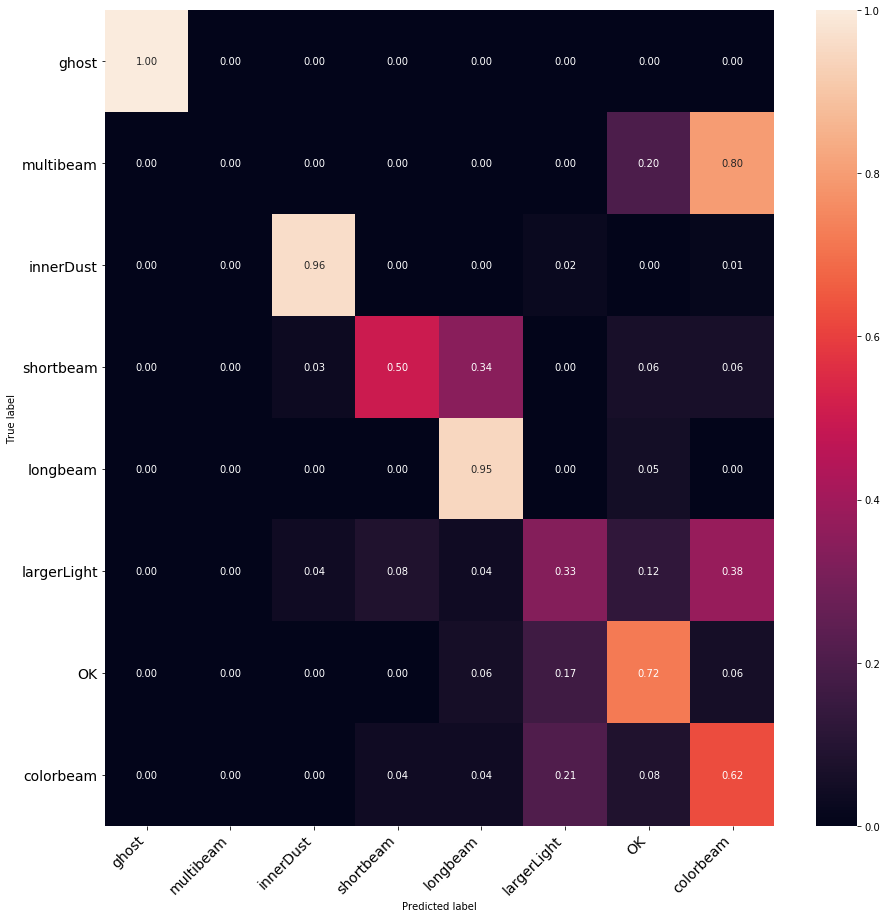

In [43]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# 小数据集上，batch size不易过大。如出现out of memory，应调小batch size
batch_size = 24
# 进程数量，最好不要超过电脑最大进程数。windows下报错可以改为workers=0
workers = 0


# predict threshold

threshold = 0.5
# epoch数量，分stage进行，跑完一个stage后降低学习率进入下一个stage
stage_epochs = [1]  
# 初始学习率
lr = 1e-4
# 学习率衰减系数 (new_lr = lr / lr_decay)
lr_decay = 0.2
# 正则化系数
weight_decay = 1e-4

# 参数初始化
stage = 0
start_epoch = 0
total_epochs = sum(stage_epochs)
best_precision = -1
best_F1 = -1
lowest_loss = 100

# 设定打印频率，即多少step打印一次，用于观察loss和acc的实时变化
# 打印结果中，括号前面为实时loss和acc，括号内部为epoch内平均loss和acc
print_freq = 1
# 验证集比例
val_ratio = 0.12
# 是否只验证，不训练
evaluate = False
# 是否从断点继续跑
resume = False
# 创建Xception模型
# model = xception()
# model.last_linear=nn.Linear(2048,8)

# 创建ResNeXt101_32x4d
# model = resnext101_64x4d()
# model.last_linear = nn.Linear(2048,8)

# 创建resnet101
# model = resnet101()
# model.last_linear = nn.Linear(2048,8)


#创建vgg19_bn
model = vgg19_bn()
model.last_linear = nn.Linear(4096,8)

model = torch.nn.DataParallel(model).cuda()



# optionally resume from a checkpoint
if resume:
    checkpoint_path = './model/%s/checkpoint.pth.tar' % file_name
    if os.path.isfile(checkpoint_path):
        print("=> loading checkpoint '{}'".format(checkpoint_path))
        checkpoint = torch.load(checkpoint_path)
        start_epoch = checkpoint['epoch'] + 1
        best_precision = checkpoint['best_precision']
        best_F1 = checkpoint['best_F1']
        lowest_loss = checkpoint['lowest_loss']
        stage = checkpoint['stage']
        lr = checkpoint['lr']
        model.load_state_dict(checkpoint['state_dict'])
        # 如果中断点恰好为转换stage的点，需要特殊处理
        if start_epoch in np.cumsum(stage_epochs)[:-1]:
            stage += 1
#             optimizer = adjust_learning_rate()
            model.load_state_dict(torch.load('./model/%s/model_best.pth.tar' % file_name)['state_dict'])
        print("=> loaded checkpoint (epoch {})".format(checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(checkpoint_path))

# 读取训练图片列表
# all_data = pd.read_csv('data/label.csv')
# # 分离训练集和测试集，stratify参数用于分层抽样
# train_data_list, val_data_list = train_test_split(all_data, test_size=val_ratio, random_state=666, stratify=all_data['label'])
# 读取测试图片列表
# test_data_list = pd.read_csv(path_to_test_info)

# 图片归一化，由于采用ImageNet预训练网络，因此这里直接采用ImageNet网络的参数
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# 训练集图片变换，输入网络的尺寸为299*299
train_data = DatasetGenerate(train_data_list,
                          transform=transforms.Compose([
                              transforms.Resize((256, 256)),
                              transforms.ColorJitter(0.15, 0.15, 0.15, 0.075),
                              transforms.RandomHorizontalFlip(),
#                               transforms.RandomGrayscale(),
                              # transforms.RandomRotation(20),
                              FixedRotation([0, 90, 180, 270]),
                              transforms.RandomCrop(224),
                              transforms.ToTensor(),
                              normalize,
                          ]))

# 验证集图片变换
val_data = DatasetGenerate(val_data_list,
                      transform=transforms.Compose([
                          transforms.Resize((256, 256)),
                          transforms.CenterCrop(224),
                          transforms.ToTensor(),
                          normalize,
                      ]))

# 测试集图片变换
# test_data = TestDataset(test_data_list,
#                         transform=transforms.Compose([
#                             transforms.Resize((320, 320)),
#                             transforms.CenterCrop(299),
#                             transforms.ToTensor(),
#                             normalize,
#                         ]))

# 生成图片迭代器
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=workers)
val_loader = DataLoader(val_data, batch_size=batch_size*2, shuffle=False, pin_memory=False, num_workers=workers)
# test_loader = DataLoader(test_data, batch_size=batch_size*2, shuffle=False, pin_memory=False, num_workers=workers)

# 使用MultiLabelSoftMarginLoss
weighted = torch.tensor(class_weighted).cuda(async=True).view(1,8)
# weighted = torch.log(weighted)
# criterion = nn.MultiLabelSoftMarginLoss(weight=torch.tensor(weighted)).cuda()
# criterion = F1Loss().cuda()
# criterion = nn.MultiLabelSoftMarginLoss().cuda()
# criterion = nn.CrossEntropyLoss(weight=weighted).cuda()
criterion = FocalLoss(gamma=0.5,alpha=class_weighted)

# 优化器，使用带amsgrad的Adam
optimizer = optim.Adam(model.parameters(), lr, weight_decay=weight_decay, amsgrad=True)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=stage_epochs, gamma=lr_decay)

if evaluate:
#     pass
    _,_,p,l,_,_=validate(val_loader, model, criterion,valwriter)
    fig = draw_cm(p,l,prob_threshold=threshold)
    fig.savefig('./result/'+file_name+'/epochs_'+str(start_epoch)+'.png')
else:
    # 开始训练
    for epoch in range(start_epoch, total_epochs):
        scheduler.step()
        # train for one epoch
        trainwriter = train(train_loader, model, criterion, optimizer, epoch,trainwriter)
        # evaluate on validation set
        precision, avg_loss,p,l,avg_f1,valwriter = validate(val_loader, model, criterion,valwriter,epoch)
        fig = draw_cm(p,l,prob_threshold=threshold)
        fig.savefig('./result/'+file_name+'/epochs_'+str(epoch)+'.png')

        # 在日志文件中记录每个epoch的精度和loss
        with open('./result/%s.txt' % file_name, 'a') as acc_file:
            acc_file.write('Epoch: %2d, Precision: %.8f, Loss: %.8f, F-score: %.8f\n' % (epoch, precision, avg_loss,avg_f1))

        # 记录最高精度与最低loss，保存最新模型与最佳模型
        is_best = precision > best_precision
        is_lowest_loss = avg_loss < lowest_loss
        is_best_f1 = avg_f1 > best_F1
        best_precision = max(precision, best_precision)
        lowest_loss = min(avg_loss, lowest_loss)
        best_F1 = max(avg_f1, best_F1)
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_precision': best_precision,
            'lowest_loss': lowest_loss,
            'best_F1':best_F1,
            'stage': stage,
            'lr': lr,
        }
        save_checkpoint(state, is_best, is_lowest_loss)

        # 判断是否进行下一个stage
        if (epoch + 1) in np.cumsum(stage_epochs)[:-1]:
            stage += 1
#             optimizer = adjust_learning_rate()
            model.load_state_dict(torch.load('./model/%s/model_best.pth.tar' % file_name)['state_dict'])
            print('Step into next stage')
            with open('./result/%s.txt' % file_name, 'a') as acc_file:
                acc_file.write('---------------Step into next stage----------------\n')
                
        trainwriter.export_scalars_to_json('./result/'+file_name+'/train-event.json')
        valwriter.export_scalars_to_json('./result/'+file_name+'/val-event.json')
trainwriter.close()
valwriter.close()
testwriter.close()

# 记录线下最佳分数
with open('./result/%s.txt' % file_name, 'a') as acc_file:
    acc_file.write('* best acc: %.8f, best f1: %.3f %s\n' % (best_precision,best_F1, file_name))
with open('./result/best_acc.txt', 'a') as acc_file:
    acc_file.write('%s  * best acc: %.8f, best f1: %.3f %s\n' % (
    time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(time.time())), best_precision,best_F1, file_name))

# 读取最佳模型，预测测试集，并生成可直接提交的结果文件
# best_model = torch.load('./model/%s/checkpoint.pth.tar' % file_name)
# model.load_state_dict(best_model['state_dict'])
# test(test_loader=val_loader, model=model,thresholder=threshold)

# 释放GPU缓存
torch.cuda.empty_cache()

In [44]:
checkpoint_path = './model/%s/checkpoint.pth.tar' % file_name
output_path = './model/%s/checkpoint.onnx' % file_name
pb_path = './model/%s/checkpoint.pb'%file_name

In [45]:
val_data.__getitem__(2)[0].max()

tensor(2.6400)

In [46]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

In [47]:
dummy_input = Variable(torch.randn(1, 3, 224,224)).cuda()
torch.onnx.export(model, dummy_input, output_path)

RuntimeError: ONNX export failed: Couldn't export Python operator Scatter

Defined at:
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\parallel\scatter_gather.py(13): scatter_map
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\parallel\scatter_gather.py(15): scatter_map
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\parallel\scatter_gather.py(28): scatter
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\parallel\scatter_gather.py(35): scatter_kwargs
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\parallel\data_parallel.py(130): scatter
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\parallel\data_parallel.py(119): forward
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py(465): _slow_forward
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py(475): __call__
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\jit\__init__.py(109): forward
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py(477): __call__
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\jit\__init__.py(77): get_trace_graph
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\onnx\utils.py(144): _trace_and_get_graph_from_model
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\onnx\utils.py(177): _model_to_graph
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\onnx\utils.py(226): _export
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\onnx\utils.py(94): export
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\torch\onnx\__init__.py(26): export
<ipython-input-47-130c3efe9a6c>(2): <module>
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py(2961): run_code
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py(2907): run_ast_nodes
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py(2785): _run_cell
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py(2662): run_cell
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\zmqshell.py(537): run_cell
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\ipkernel.py(208): do_execute
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\kernelbase.py(399): execute_request
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\kernelbase.py(233): dispatch_shell
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\kernelbase.py(283): dispatcher
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\tornado\stack_context.py(300): null_wrapper
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\zmq\eventloop\zmqstream.py(432): _run_callback
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\zmq\eventloop\zmqstream.py(480): _handle_recv
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\zmq\eventloop\zmqstream.py(450): _handle_events
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\zmq\eventloop\zmqstream.py(536): <lambda>
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\tornado\stack_context.py(300): null_wrapper
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\tornado\ioloop.py(758): _run_callback
C:\Users\sunny\Anaconda3\envs\pytorch\lib\asyncio\events.py(127): _run
C:\Users\sunny\Anaconda3\envs\pytorch\lib\asyncio\base_events.py(1425): _run_once
C:\Users\sunny\Anaconda3\envs\pytorch\lib\asyncio\base_events.py(421): run_forever
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\tornado\platform\asyncio.py(132): start
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\kernelapp.py(499): start
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\traitlets\config\application.py(658): launch_instance
C:\Users\sunny\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py(3): <module>
C:\Users\sunny\Anaconda3\envs\pytorch\lib\runpy.py(85): _run_code
C:\Users\sunny\Anaconda3\envs\pytorch\lib\runpy.py(193): _run_module_as_main


Graph we tried to export:
graph(%0 : Float(1, 3, 224, 224)
      %1 : Float(64, 3, 3, 3)
      %2 : Float(64)
      %3 : Float(64)
      %4 : Float(64)
      %5 : Float(64)
      %6 : Float(64)
      %7 : Long()
      %8 : Float(64, 64, 3, 3)
      %9 : Float(64)
      %10 : Float(64)
      %11 : Float(64)
      %12 : Float(64)
      %13 : Float(64)
      %14 : Long()
      %15 : Float(128, 64, 3, 3)
      %16 : Float(128)
      %17 : Float(128)
      %18 : Float(128)
      %19 : Float(128)
      %20 : Float(128)
      %21 : Long()
      %22 : Float(128, 128, 3, 3)
      %23 : Float(128)
      %24 : Float(128)
      %25 : Float(128)
      %26 : Float(128)
      %27 : Float(128)
      %28 : Long()
      %29 : Float(256, 128, 3, 3)
      %30 : Float(256)
      %31 : Float(256)
      %32 : Float(256)
      %33 : Float(256)
      %34 : Float(256)
      %35 : Long()
      %36 : Float(256, 256, 3, 3)
      %37 : Float(256)
      %38 : Float(256)
      %39 : Float(256)
      %40 : Float(256)
      %41 : Float(256)
      %42 : Long()
      %43 : Float(256, 256, 3, 3)
      %44 : Float(256)
      %45 : Float(256)
      %46 : Float(256)
      %47 : Float(256)
      %48 : Float(256)
      %49 : Long()
      %50 : Float(256, 256, 3, 3)
      %51 : Float(256)
      %52 : Float(256)
      %53 : Float(256)
      %54 : Float(256)
      %55 : Float(256)
      %56 : Long()
      %57 : Float(512, 256, 3, 3)
      %58 : Float(512)
      %59 : Float(512)
      %60 : Float(512)
      %61 : Float(512)
      %62 : Float(512)
      %63 : Long()
      %64 : Float(512, 512, 3, 3)
      %65 : Float(512)
      %66 : Float(512)
      %67 : Float(512)
      %68 : Float(512)
      %69 : Float(512)
      %70 : Long()
      %71 : Float(512, 512, 3, 3)
      %72 : Float(512)
      %73 : Float(512)
      %74 : Float(512)
      %75 : Float(512)
      %76 : Float(512)
      %77 : Long()
      %78 : Float(512, 512, 3, 3)
      %79 : Float(512)
      %80 : Float(512)
      %81 : Float(512)
      %82 : Float(512)
      %83 : Float(512)
      %84 : Long()
      %85 : Float(512, 512, 3, 3)
      %86 : Float(512)
      %87 : Float(512)
      %88 : Float(512)
      %89 : Float(512)
      %90 : Float(512)
      %91 : Long()
      %92 : Float(512, 512, 3, 3)
      %93 : Float(512)
      %94 : Float(512)
      %95 : Float(512)
      %96 : Float(512)
      %97 : Float(512)
      %98 : Long()
      %99 : Float(512, 512, 3, 3)
      %100 : Float(512)
      %101 : Float(512)
      %102 : Float(512)
      %103 : Float(512)
      %104 : Float(512)
      %105 : Long()
      %106 : Float(512, 512, 3, 3)
      %107 : Float(512)
      %108 : Float(512)
      %109 : Float(512)
      %110 : Float(512)
      %111 : Float(512)
      %112 : Long()
      %113 : Float(4096, 25088)
      %114 : Float(4096)
      %115 : Float(4096, 4096)
      %116 : Float(4096)
      %117 : Float(8, 4096)
      %118 : Float(8)) {
  %119 : Float(1, 3, 224, 224) = ^Scatter([0], None, 0)(%0), scope: DataParallel
  %120 : Float(1, 64, 224, 224) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%119, %1, %2), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[0]
  %121 : Float(1, 64, 224, 224) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%120, %3, %4, %5, %6), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[1]
  %122 : Float(1, 64, 224, 224) = onnx::Relu(%121), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[2]
  %123 : Float(1, 64, 224, 224) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%122, %8, %9), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[3]
  %124 : Float(1, 64, 224, 224) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%123, %10, %11, %12, %13), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[4]
  %125 : Float(1, 64, 224, 224) = onnx::Relu(%124), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[5]
  %126 : Float(1, 64, 112, 112) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%125), scope: DataParallel/VGG[module]/Sequential[_features]/MaxPool2d[6]
  %127 : Float(1, 128, 112, 112) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%126, %15, %16), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[7]
  %128 : Float(1, 128, 112, 112) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%127, %17, %18, %19, %20), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[8]
  %129 : Float(1, 128, 112, 112) = onnx::Relu(%128), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[9]
  %130 : Float(1, 128, 112, 112) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%129, %22, %23), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[10]
  %131 : Float(1, 128, 112, 112) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%130, %24, %25, %26, %27), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[11]
  %132 : Float(1, 128, 112, 112) = onnx::Relu(%131), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[12]
  %133 : Float(1, 128, 56, 56) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%132), scope: DataParallel/VGG[module]/Sequential[_features]/MaxPool2d[13]
  %134 : Float(1, 256, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%133, %29, %30), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[14]
  %135 : Float(1, 256, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%134, %31, %32, %33, %34), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[15]
  %136 : Float(1, 256, 56, 56) = onnx::Relu(%135), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[16]
  %137 : Float(1, 256, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%136, %36, %37), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[17]
  %138 : Float(1, 256, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%137, %38, %39, %40, %41), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[18]
  %139 : Float(1, 256, 56, 56) = onnx::Relu(%138), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[19]
  %140 : Float(1, 256, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%139, %43, %44), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[20]
  %141 : Float(1, 256, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%140, %45, %46, %47, %48), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[21]
  %142 : Float(1, 256, 56, 56) = onnx::Relu(%141), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[22]
  %143 : Float(1, 256, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%142, %50, %51), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[23]
  %144 : Float(1, 256, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%143, %52, %53, %54, %55), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[24]
  %145 : Float(1, 256, 56, 56) = onnx::Relu(%144), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[25]
  %146 : Float(1, 256, 28, 28) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%145), scope: DataParallel/VGG[module]/Sequential[_features]/MaxPool2d[26]
  %147 : Float(1, 512, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%146, %57, %58), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[27]
  %148 : Float(1, 512, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%147, %59, %60, %61, %62), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[28]
  %149 : Float(1, 512, 28, 28) = onnx::Relu(%148), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[29]
  %150 : Float(1, 512, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%149, %64, %65), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[30]
  %151 : Float(1, 512, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%150, %66, %67, %68, %69), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[31]
  %152 : Float(1, 512, 28, 28) = onnx::Relu(%151), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[32]
  %153 : Float(1, 512, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%152, %71, %72), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[33]
  %154 : Float(1, 512, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%153, %73, %74, %75, %76), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[34]
  %155 : Float(1, 512, 28, 28) = onnx::Relu(%154), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[35]
  %156 : Float(1, 512, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%155, %78, %79), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[36]
  %157 : Float(1, 512, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%156, %80, %81, %82, %83), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[37]
  %158 : Float(1, 512, 28, 28) = onnx::Relu(%157), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[38]
  %159 : Float(1, 512, 14, 14) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%158), scope: DataParallel/VGG[module]/Sequential[_features]/MaxPool2d[39]
  %160 : Float(1, 512, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%159, %85, %86), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[40]
  %161 : Float(1, 512, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%160, %87, %88, %89, %90), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[41]
  %162 : Float(1, 512, 14, 14) = onnx::Relu(%161), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[42]
  %163 : Float(1, 512, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%162, %92, %93), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[43]
  %164 : Float(1, 512, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%163, %94, %95, %96, %97), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[44]
  %165 : Float(1, 512, 14, 14) = onnx::Relu(%164), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[45]
  %166 : Float(1, 512, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%165, %99, %100), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[46]
  %167 : Float(1, 512, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%166, %101, %102, %103, %104), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[47]
  %168 : Float(1, 512, 14, 14) = onnx::Relu(%167), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[48]
  %169 : Float(1, 512, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%168, %106, %107), scope: DataParallel/VGG[module]/Sequential[_features]/Conv2d[49]
  %170 : Float(1, 512, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, is_test=1, momentum=1](%169, %108, %109, %110, %111), scope: DataParallel/VGG[module]/Sequential[_features]/BatchNorm2d[50]
  %171 : Float(1, 512, 14, 14) = onnx::Relu(%170), scope: DataParallel/VGG[module]/Sequential[_features]/ReLU[51]
  %172 : Float(1, 512, 7, 7) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%171), scope: DataParallel/VGG[module]/Sequential[_features]/MaxPool2d[52]
  %173 : Dynamic = onnx::Shape(%172), scope: DataParallel/VGG[module]
  %174 : Dynamic = onnx::Slice[axes=[0], ends=[1], starts=[0]](%173), scope: DataParallel/VGG[module]
  %175 : Long() = onnx::Squeeze[axes=[0]](%174), scope: DataParallel/VGG[module]
  %176 : Long() = onnx::Constant[value={-1}](), scope: DataParallel/VGG[module]
  %177 : Dynamic = onnx::Unsqueeze[axes=[0]](%175), scope: DataParallel/VGG[module]
  %178 : Dynamic = onnx::Unsqueeze[axes=[0]](%176), scope: DataParallel/VGG[module]
  %179 : Dynamic = onnx::Concat[axis=0](%177, %178), scope: DataParallel/VGG[module]
  %180 : Float(1, 25088) = onnx::Reshape(%172, %179), scope: DataParallel/VGG[module]
  %181 : Float(1, 4096) = onnx::Gemm[alpha=1, beta=1, broadcast=1, transB=1](%180, %113, %114), scope: DataParallel/VGG[module]/Linear[linear0]
  %182 : Float(1, 4096) = onnx::Relu(%181), scope: DataParallel/VGG[module]/ReLU[relu0]
  %183 : Float(1, 4096), %184 : Dynamic = onnx::Dropout[is_test=1, ratio=0.5](%182), scope: DataParallel/VGG[module]/Dropout[dropout0]
  %185 : Float(1, 4096) = onnx::Gemm[alpha=1, beta=1, broadcast=1, transB=1](%183, %115, %116), scope: DataParallel/VGG[module]/Linear[linear1]
  %186 : Float(1, 4096) = onnx::Relu(%185), scope: DataParallel/VGG[module]/ReLU[relu1]
  %187 : Float(1, 4096), %188 : Dynamic = onnx::Dropout[is_test=1, ratio=0.5](%186), scope: DataParallel/VGG[module]/Dropout[dropout1]
  %189 : Float(1, 8) = onnx::Gemm[alpha=1, beta=1, broadcast=1, transB=1](%187, %117, %118), scope: DataParallel/VGG[module]/Linear[last_linear]
  return (%189);
}


In [ ]:
import netron
netron.start(output_path)

In [ ]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX file
model = onnx.load(output_path)

# Import the ONNX model to Tensorflow
tf_rep = prepare(model,strict=False)

In [ ]:
print(tf_rep.inputs)

In [ ]:
print(tf_rep.outputs)

In [ ]:
print(tf_rep.tensor_dict)

In [ ]:
print(tf_rep.graph)

In [ ]:
image = 'data/NG/longbeam/7 (6).bmp'

In [ ]:
import numpy as np
from IPython.display import display
from PIL import Image

print('Image 1:')
img = Image.open(image).resize((256, 256))
display(img)
width, height = img.size

new_width,new_height = 224,224
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

img1 = img.crop((left, top, right, bottom))

display(img1)
img1 = np.asarray(img1, dtype=np.float32)/255.0
imgarray = ((img1-np.array([0.485, 0.456, 0.406]))/np.array([0.229, 0.224, 0.225])).reshape((1,3,224,224))

print()

output = tf_rep.run(imgarray)
print('The digit is classified as ', np.argmax(output))

# print('Image 2:')
# img = Image.open('assets/three.png').resize((28, 28)).convert('L')
# display(img)
# output = tf_rep.run(np.asarray(img, dtype=np.float32)[np.newaxis, np.newaxis, :, :])
# print('The digit is classified as ', np.argmax(output))

In [ ]:
tf_rep.export_graph(pb_path)

In [ ]:
label_names

In [ ]:
output

In [ ]:
output